## SMS Text Classification
#### Section 2 : Prof. Tanya Roosta

### Members:
#### Hillary Chang, hillary_chang@berkeley.edu
#### Raji Chandrasekaran,  raji.chandrasekaran@berkeley.edu
#### Song Gao, song_gao@berkeley.edu


### Motivation
####  Natural Language Processing and text classification is something that is fundamentally required at a place where we are all bombarded with spam emails, messages etc. While classifying as SPAM or HAM is the beginning, text mining applications such as classifying if the author is showing irony or anger or other emotion is the next best application to develop using NLP.

In [1]:
DATA_FILE_PATH = "/content/w207/SMSSpamCollection"

In [2]:
# standard libraries
import pandas as pd
import numpy as np
import os
import random

# visualizations
import matplotlib.pyplot as plt
from IPython.display import Image
from mlxtend.plotting import heatmap
from mlxtend.plotting import plot_decision_regions
%matplotlib inline

# sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

# tf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import initializers

random.seed(2)


In [3]:
df = pd.read_csv(DATA_FILE_PATH, encoding='ISO-8859-1')
df = df[['v1', 'v2']].rename(columns={'v1': 'label', 'v2': 'message'})
print(df.head())

  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


In [4]:
# df = pd.read_csv("", sep='\t', header=None, names=["label", "message"])

# df.head()

In [5]:
# Initial data counts
print(df.shape)
print(df['label'].value_counts())

(5572, 2)
label
ham     4825
spam     747
Name: count, dtype: int64


In [6]:
# converting labels to numeric identifiers
df['label_num'] = df['label'].map({'ham': 0, 'spam': 1})

In [7]:
df.head()

,label,message,label_num
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


#### The message contains punctuations and uppercase and lowercase and spaces. We will need to standardize this using string pre processing. The folllowing function will handle all string pre processing needs

In [8]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def clean_text(text):
    text = text.lower()                              # lowercase
    text = re.sub(f"[{string.punctuation}]", "", text)  # remove punctuation
    words = text.split()                             # tokenize
    words = [stemmer.stem(word) for word in words if word not in stop_words]
    return " ".join(words)

df['clean_message'] = df['message'].apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
df.head()

,label,message,label_num,clean_message
0,ham,"Go until jurong point, crazy.. Available only ...",0,go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,0,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,free entri 2 wkli comp win fa cup final tkt 21...
3,ham,U dun say so early hor... U c already then say...,0,u dun say earli hor u c alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,nah dont think goe usf live around though


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   label          5572 non-null   object
 1   message        5572 non-null   object
 2   label_num      5572 non-null   int64 
 3   clean_message  5572 non-null   object
dtypes: int64(1), object(3)
memory usage: 174.3+ KB


#### Noticing that stemmer is converting "Entry" to "enrti" that may loose its original value. Trying Lemmetizer instead of stemmer

In [11]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

lemmatizer = WordNetLemmatizer()

def clean_text_with_lemmatizer(text):
    text = text.lower()
    text = re.sub(f"[{string.punctuation}]", "", text)
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return " ".join(words)

df['clean_lem_message'] = df['message'].apply(clean_text_with_lemmatizer)

In [12]:
df.head()

,label,message,label_num,clean_message,clean_lem_message
0,ham,"Go until jurong point, crazy.. Available only ...",0,go jurong point crazi avail bugi n great world...,go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,0,ok lar joke wif u oni,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,free entri 2 wkli comp win fa cup final tkt 21...,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,0,u dun say earli hor u c alreadi say,u dun say early hor u c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,nah dont think goe usf live around though,nah dont think go usf life around though


In [13]:
# Other outlier detection & null values detection for a cleaner dataset before we split for train test and validation
print(df.isnull().sum())

label                0
message              0
label_num            0
clean_message        0
clean_lem_message    0
dtype: int64


EDA & Visualizations

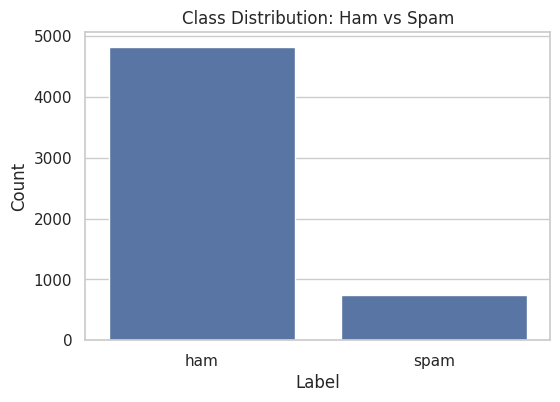

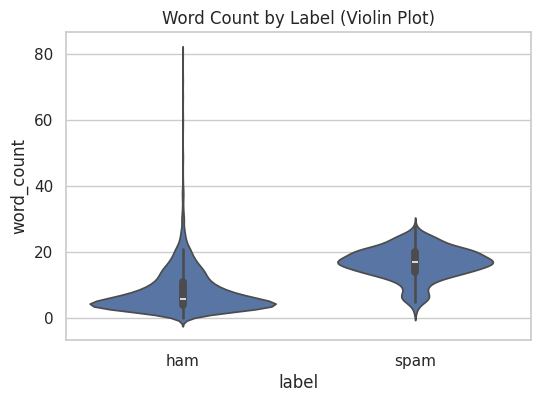

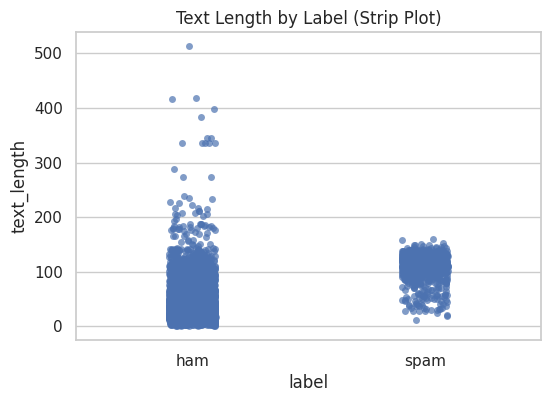

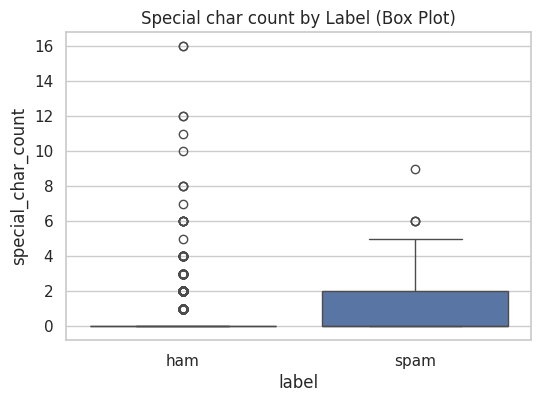

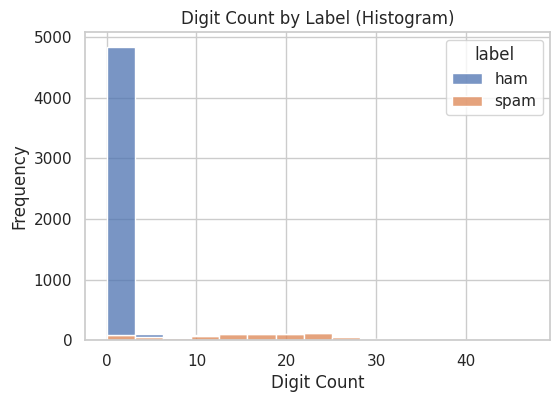

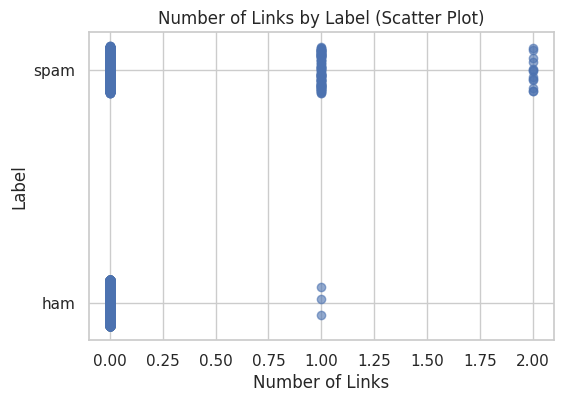

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Add more features for spam detections
df['word_count'] = df['clean_lem_message'].apply(lambda x: len(x.split()))
df['text_length'] = df['clean_lem_message'].apply(lambda x: len(x))
df['special_char_count'] = df['clean_lem_message'].apply(lambda x: len(re.findall(r'[^A-Za-z0-9 ]', x)))
df['digit_count'] = df['clean_lem_message'].apply(lambda x: sum(c.isdigit() for c in x))
df['num_links'] = df['clean_lem_message'].apply(lambda x: len(re.findall(r'(http|www|\.com)', x.lower())))

# Set seaborn style
sns.set(style="whitegrid")

# Plot 1: Class Distribution (Bar Plot)
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df)
plt.title("Class Distribution: Ham vs Spam")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

# Plot 2: Word Count (Violin Plot)
plt.figure(figsize=(6, 4))
sns.violinplot(x='label', y='word_count', data=df)
plt.title("Word Count by Label (Violin Plot)")
plt.show()

# Plot 3: Text Length (Strip Plot)
plt.figure(figsize=(6, 4))
sns.stripplot(x='label', y='text_length', data=df, jitter=True, alpha=0.7)
plt.title("Text Length by Label (Strip Plot)")
plt.show()

# Plot 4: Special Char Count (Box Plot)
plt.figure(figsize=(6, 4))
sns.boxplot(x='label', y='special_char_count', data=df)
plt.title("Special char count by Label (Box Plot)")
plt.show()

# Plot 5: Digit Count (Histogram)
plt.figure(figsize=(6, 4))
sns.histplot(data=df, x='digit_count', hue='label', multiple='stack', bins=15)
plt.title("Digit Count by Label (Histogram)")
plt.xlabel("Digit Count")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Plot 6: Number of Links (Scatter)
# Map labels to numeric values
label_map = {'ham': 0, 'spam': 1}
df['label_numeric'] = df['label'].map(label_map)
# Add jitter to the y-axis for better visual separation
y_jitter = df['label_numeric'] + np.random.uniform(-0.1, 0.1, size=len(df))
plt.figure(figsize=(6, 4))
plt.scatter(df['num_links'], y_jitter, alpha=0.6)
plt.yticks([0, 1], ['ham', 'spam'])
plt.xlabel("Number of Links")
plt.ylabel("Label")
plt.title("Number of Links by Label (Scatter Plot)")
plt.grid(True)
plt.show()




#### These features — text length, word count, uppercase usage, digit presence, and number of links — show clear patterns that can effectively distinguish spam from ham. They provide valuable input for training a reliable classification model.